In [1]:
!pip install sklearn
!pip install scikit-learn-extra
!pip install pandas
!pip install dimod

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2951 sha256=124b1d966ea9a6de22e73f8ac877a0f0ddcc49161ac7d3e394f754475e15125a
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 30.0 MB/s eta 0:00:00


<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>
Introduction to k-medoids Clustering with Leap's Hybrid solvers.
====================

Forewords
---------------------

This notebook is intended to provide a gentle and step by step introduction
to our Hybrid k-Medoids clustering algorithm.
As detailed in our technical report for Matmut, the Hybrid k-clustering routine relies on an empirical QUBO formulation of te k-medoids problem. Thus we begin with a bried reminder about the QUBO formulation of k-medoids clustering. A detailed introduction to k-means/k-medoids clustering can be found in Part. 2 Section. 1,of the report which is attached to this notebook. The detailed derivation of the empirical QUBO formulation of $k$-medoids clustering can be found in Part.2 Section. 2.

QUBO k-medoids
--------------------

In 2019, Bauckhage et al. formulated an empirical QUBO model to find the $k$ medoids of a given dataset without explicitly computing the cluster. Their empirical QUBO is based on the following empirical definition of 'good' medoids:

<div style='text-align: center;'>
  Points of the $original~dataset$ that are similar to the data points within their cluster and, at the same
time, dissimilar from each other.
</div>

<br>
This definition can be formulated mathematically under the form of $quadractic~unconstrained~binary~optimization$ (QUBO) model. Namely, the empirical QUBO formulation of $k$-medoids reads as follows:
<div style='text-align: center;'>
$\begin{align}
\label{QUBO_medoid}
    \boldsymbol{z}^*&=\underset{\boldsymbol{z}\in\{0,1\}^N}{\text{argmin}}~E(\boldsymbol{z}),\\\label{energy_function}E(\boldsymbol{z})&\equiv f(\boldsymbol{z})+\gamma*P(\boldsymbol{z})=\frac{\beta}{2}\boldsymbol{z}^T\boldsymbol{\Delta}\boldsymbol{1}-\frac{\alpha}{2}\boldsymbol{z}^T\boldsymbol{\Delta}\boldsymbol{z}+\gamma\left(\boldsymbol{z}^T\boldsymbol{1}-k\right)^2
\end{align}$
</div>
Where $\boldsymbol{z}$ is a binary vector indicator whose entries are defined ad follows:

$\alpha$ and $\beta$ are trade-off parameters, $\boldsymbol{\Delta}$ is the dissimiliraty matrix of the dataset $X$ to be clustered and $\gamma$ the Lagrange parameter associated to the constraint $\sum_iz_i=k$, i.e, finding exactly $k$ medoids.

As detailed
All objects and methods related to QUBO k-medoid clustering are implemented in the 'medoid.py' file.
Useful routines to post-process and analyze the clustering models are implemented in the 'utils.py' file.

Practical example
=================

Let us now illustrate how to practically perform QUBO k-medoids cluster with our libraries on very small toy datasets made of Gaussian blobs.


In [2]:
#Let us import relevant libraries
import numpy as np
# To create the QUBO and solve it, we need Ocean so import it
import dimod
# For visualization:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
# The 'QbitSoft' colormap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#00ff9e","#1d6fc3","#0b268c"])
#For data generation
from sklearn import cluster, datasets
from scipy.stats import qmc
from utils import generate_standardized_blob_dataset_fixed_centers
# For comparison woth PAM
from sklearn_extra.cluster import KMedoids
# Import the QUBO Kmedoids model from medoids.py:
from medoid import QUBO_KMedoids

Generating the Dataset
----------------------
For simplicity let us create a toy dataset containing 20 samples grouped in 3 Gaussian clusters without overlap.

In [3]:
# First find the center of the Gaussian blobs to avoid any overlap of the clusters
radius=0.2
std_dev=radius/7
n_clusters=3
n_samples=20
i=0
list_centers=[]
engine = qmc.PoissonDisk(d=2, radius=radius, seed=32)
centers =engine.random(n_clusters)
list_centers.append((n_clusters,centers))
X,y=generate_standardized_blob_dataset_fixed_centers(n_samples,centers,save_data=False,path=None,std_dev=std_dev)


We can now visualize the 2D dataset


(-2.0, 2.0)

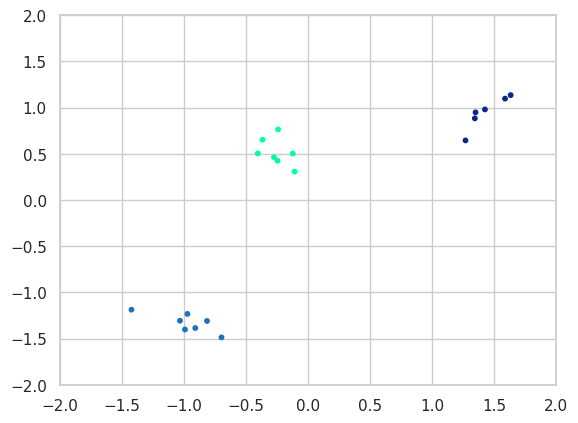

In [4]:
sns.set()
sns.set_style('whitegrid')
plt.scatter(X[:,0],X[:,1],c=y,s=10,cmap=cmap)
plt.xlim(-2,2)
plt.ylim(-2,2)

Dissimilarity Matrix
-------
Having created the dataset we now have to compute its dissimilarity matric $\boldsymbol{\Delta}$.
To that end we first compute the Euclidean distance matrix, which will be useful latter to compute the metrics
assessing the quality of our clustering models.
<br>Remark: In practice for large datasets, you should compute once for all these matrices, save it as textfiles and read from these files when you want to use them.

In [5]:
from sklearn.metrics import pairwise_distances
euclid_delta_mtx=pairwise_distances(X)

# set sigma to 1 arbitrarily for the moment (in practice sigma have to be fine tuned)
sigma=1
delta_mtx=(1-np.exp(-euclid_delta_mtx**2/2/sigma**2))


QUBO $k$-medoids clustering
------
Now we have all elements needed to perform QUBO $k$-medoids with your favorite solver.
To avoid D-wave Quota consumption, let us examplify QUBO $k$-medoids with the dimod.ExactSolver,
simulated annealing and Tabu search and compare there results to the one of PAM.
Let us begin with the Exact Solver of Ocean. Since this solver is not implemented in the QUBO_KMedoids class, we should first build the
QUBO model associated to the dataset X and then solve it with the ExactSolver.



In [6]:
#Instantiate a Kmedoids model with k=3
QUBOKmedoids=QUBO_KMedoids(n_clusters=3)
#Build the QUBO corresponding to the dataset X.
QUBO_model=QUBOKmedoids.build_qubo_as_bqm(delta_mtx)
print(QUBO_model)


BinaryQuadraticModel({0: -0.42889679830265726, 1: -0.48363497818694556, 2: -0.48337101555699, 3: -0.5182838824740812, 4: -0.4308242188524012, 5: -0.44681815237500144, 6: -0.5148811574440934, 7: -0.442780287032991, 8: -0.43651075783417204, 9: -0.38903999589433624, 10: -0.43164820998624076, 11: -0.43782569851953324, 12: -0.507774238478338, 13: -0.41812835670825077, 14: -0.4348473553374369, 15: -0.49294270785653727, 16: -0.3954196870509912, 17: -0.417056305463379, 18: -0.5114472656182932, 19: -0.37948100669988394}, {(1, 0): 0.15823494821212597, (2, 0): 0.17752943415446024, (2, 1): 0.41399984292798736, (3, 0): 0.17895571090956008, (3, 1): 0.38897637731584855, (3, 2): 0.38291720041692745, (4, 0): 0.08669849716665173, (4, 1): 0.11860218339461853, (4, 2): 0.10944056138253533, (4, 3): 0.13771690035058864, (5, 0): 0.08742145697377623, (5, 1): 0.13228067461105847, (5, 2): 0.1200840940773325, (5, 3): 0.15542827844583434, (5, 4): 0.413902681365945, (6, 0): 0.18711234114898778, (6, 1): 0.4053060700

With the QUBO in hands we can now use the ExactSolver to solve it and obtain our medoids:
    

In [7]:
exact_solver=dimod.ExactSolver()
response=exact_solver.sample(QUBO_model)
exact_samples=response.record.sample
exact_energies=response.record.energy
print(exact_samples.shape,exact_energies.shape)

(1048576, 20) (1048576,)


The ExactSolver enumerate all possible configuration of the binary vector $\boldsymbol{z}$ and evaluate their associated energies. It is a brute force method that necessarily finds the exact solution of the QUBO instance. Nevertheless for more than 30-50 variables it becomes intractable on standard laptops.

In [8]:
exact_energy=np.min(exact_energies)
exact_solution=exact_samples[np.argmin(exact_energies),:]
print(exact_energy,exact_solution)

-0.9857627065010066 [1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


Now we have find the exact solution $\boldsymbol{z}^*$ to our QUBO. Therefore we exactly know the indices of the medoids and hence their position. The last step to perform clustering is therefore to assign all points of the dataset to their closest medoids. After that we can directly visualize the results of our clustering model and compare it to the true cluster labels.


In [9]:
exact_medoids_indices=np.argwhere(exact_solution==1).T[0,:]
exact_labels=np.argmin(delta_mtx[:,exact_medoids_indices],axis=1)

(-2.0, 2.0)

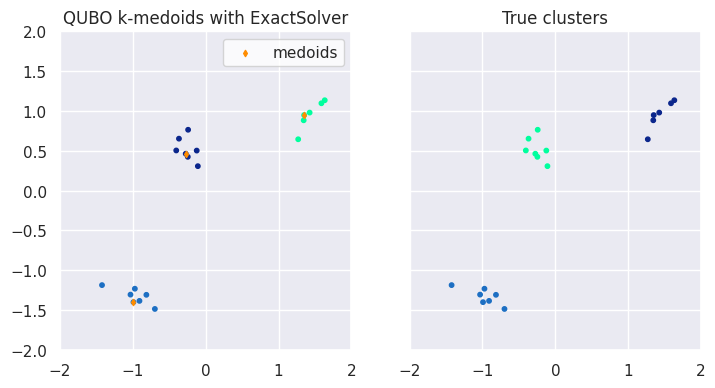

In [10]:
sns.set()
fig,[ax0,ax1]=plt.subplots(1,2,figsize=(8.27,8.27/2),sharex=True,sharey=True)
sns.set_style('whitegrid')
ax0.scatter(X[:,0],X[:,1],c=exact_labels,s=10,cmap=cmap,alpha=1)
ax1.scatter(X[:,0],X[:,1],c=y,s=10,cmap=cmap,alpha=1)
ax0.scatter(X[exact_medoids_indices,0],X[exact_medoids_indices,1],color='darkorange',marker='d',s=10,label='medoids')
ax0.set_title('QUBO k-medoids with ExactSolver')
ax1.set_title('True clusters')
ax0.legend(loc='best')
plt.xlim(-2,2)
plt.ylim(-2,2)

One can observe that there is a perfect agreement between the results of our QUBO k-medoids clustering model and the exact labels. Let us now use different solver that are already implemented in QUBO_Kmedoids class. For these solvers, there is no need to do all the steps detailed above by hand. They are directly implemented as simple method. In addition all clustering metrics can be computed thanks to function in the utils library. We will examplify it in the follwing when comparing the performance of QUBO k-medoids with the simulated annnealing solver to PAM.

In [11]:
#define a QUBO_KMedoids instance for the simulated annealing clustering model:
SA_kmedoids=QUBO_KMedoids(n_clusters=3)
#Since simulated annealing is a stochastic routine we have acquire statistics to
#accuralety characterize its performance (see the report for details)
#Thus we initialize lists to store the results of all runs
sa_labels=[]
sa_medoids=[]
sa_energies=[]
sa_objective=[]
sa_inertias=[]
sa_silhouettes=[]
from utils import silhouette_score, inertia_from_labels_and_medoids_indices,objective_from_medoids_indices
for n_run in range(50):
    SA_kmedoids.simulated_annealing_fit(delta_mtx,alpha=None,beta=None,gamma=None,num_reads=50)
    sa_labels.append(SA_kmedoids.labels_)
    sa_medoids.append(SA_kmedoids.medoids_indices_)
    sa_energies.append(SA_kmedoids.energy)
    sa_objective.append(objective_from_medoids_indices(delta_mtx,SA_kmedoids.medoids_indices_,3))
    sa_silhouettes.append(silhouette_score(euclid_delta_mtx,SA_kmedoids.labels_,metric='precomputed'))
    sa_inertias.append(inertia_from_labels_and_medoids_indices(euclid_delta_mtx,SA_kmedoids.labels_,SA_kmedoids.medoids_indices_))


ModuleNotFoundError: ignored

Now we run PAM for comparison :

In [ ]:
#Define KMedoids instance to store the PAM model:
pam_kmedoid= KMedoids(metric='precomputed',n_clusters=n_clusters,method='pam').fit(delta_mtx)
pam_labels=pam_kmedoid.labels_
pam_medoids=pam_kmedoid.medoid_indices_
pam_inertia=inertia_from_labels_and_medoids_indices(euclid_delta_mtx,pam_labels,pam_medoids)
pam_objective=objective_from_medoids_indices(delta_mtx,pam_medoids,3)
pam_silhouette=silhouette_score(euclid_delta_mtx,pam_labels,metric='precomputed')


Text(0, 0.5, 'objective')

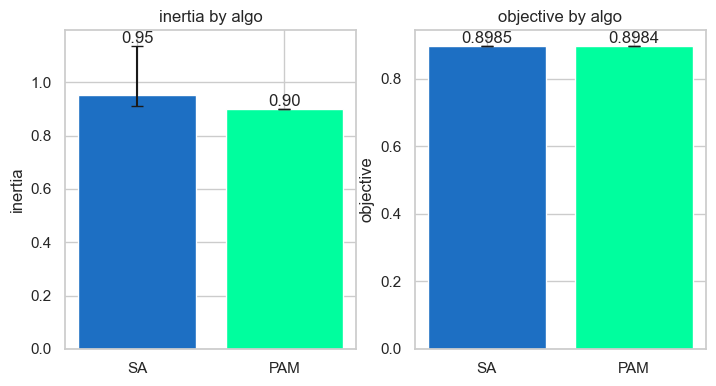

In [ ]:
#compare the metrics:
sns.set()
sns.set_style('whitegrid')
fig, (ax0,ax1)=plt.subplots(1,2,figsize=(8.27,8.27/2))
error=[[np.abs(np.min(np.array(sa_inertias))-np.mean(np.array(sa_inertias))),0],[np.abs(np.max(np.array(sa_inertias))-np.mean(np.array(sa_inertias))),0]]
rects=ax0.bar([1,2],[np.mean(np.array(sa_inertias)),pam_inertia],color=[cmap(0.5),cmap(1)],\
       yerr=error, capsize=4)
ax0.bar_label(rects, padding=0,fmt='{:04.2f}',fontsize=12)
ax0.set_title('inertia by algo')
ax0.set_xticks([1,2],['SA','PAM'])
ax0.set_ylabel('inertia',fontsize=12)
error=[[np.abs(np.min(np.array(sa_objective))-np.mean(np.array(sa_objective))),0],[np.abs(np.max(np.array(sa_objective))-np.mean(np.array(sa_objective))),0]]
rects=ax1.bar([1,2],[np.mean(np.array(sa_objective)),pam_objective],color=[cmap(0.5),cmap(1)],\
       yerr=error, capsize=4)
ax1.bar_label(rects, padding=0,fmt='{:04.4f}',fontsize=12)
ax1.set_title('objective by algo')
ax1.set_xticks([1,2],['SA','PAM'])
ax1.set_ylabel('objective',fontsize=12)

Text(0, 0.5, 'silhouette score')

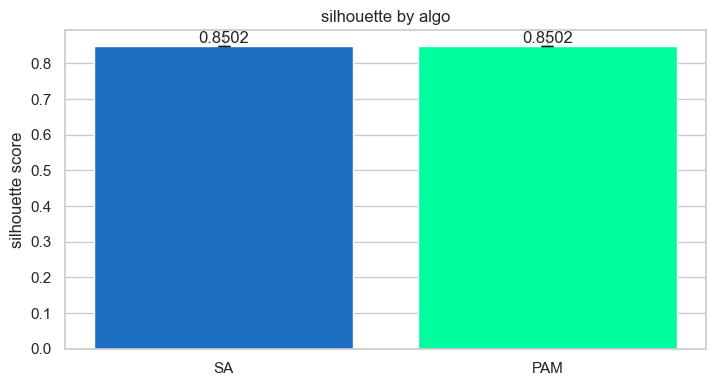

In [ ]:
sns.set()
sns.set_style('whitegrid')
fig, (ax0)=plt.subplots(1,figsize=(8.27,8.27/2))
error=[[np.abs(np.min(np.array(sa_silhouettes))-np.mean(np.array(sa_silhouettes))),0],[np.abs(np.max(np.array(sa_silhouettes))-np.mean(np.array(sa_silhouettes))),0]]
rects=ax0.bar([1,2],[np.mean(np.array(sa_silhouettes)),pam_silhouette],color=[cmap(0.5),cmap(1)],\
       yerr=error, capsize=4)
ax0.bar_label(rects, padding=0,fmt='{:04.4f}',fontsize=12)
ax0.set_title('silhouette by algo')
ax0.set_xticks([1,2],['SA','PAM'])
ax0.set_ylabel('silhouette score',fontsize=12)


Notice that the silhouette scores are equal. This is due to the fact that the two models have the same clusters but the position of their medoids are different.
To show it let us plot the clusters and medoids for the two models. For the SA clustering we plot the clusters and medoids with lowest energy, i.e. the best soltuions among the 50 runs.


(-2.0, 2.0)

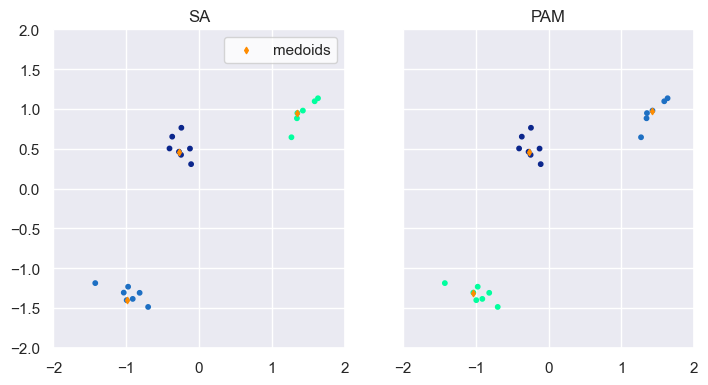

In [ ]:
sns.set()
fig,[ax0,ax1]=plt.subplots(1,2,figsize=(8.27,8.27/2),sharex=True,sharey=True)
sns.set_style('whitegrid')
best_sa_labels=np.array(sa_labels)[np.argmin(np.array(sa_energies)),:]
best_sa_medoids=np.array(sa_medoids)[np.argmin(np.array(sa_energies)),:]
ax0.scatter(X[:,0],X[:,1],c=best_sa_labels,s=10,cmap=cmap,alpha=1)
ax1.scatter(X[:,0],X[:,1],c=pam_labels,s=10,cmap=cmap,alpha=1)
ax0.scatter(X[best_sa_medoids,0],X[best_sa_medoids,1],color='darkorange',marker='d',s=10,label='medoids')
ax1.scatter(X[pam_medoids,0],X[pam_medoids,1],color='darkorange',marker='d',s=10,label='medoids')
ax0.set_title('SA')
ax1.set_title('PAM')
ax0.legend(loc='best')
plt.xlim(-2,2)
plt.ylim(-2,2)

Now you can run the QUBO k-medoids using the Leap's hybrid solver.
To that end you should first declare your client ID.

In [ ]:
import os
os.environ['DWAVE_API_TOKEN'] ='Your TOKEN'

Then you just have to instantiate a QUBO_KMedoids instance and fit the model using the LeapHyrbid_fit method:

In [ ]:
hybrid_kmedoids=QUBO_KMedoids(n_clusters=3)
hybrid_kmedoids.LeapHybrid_fit(delta_mtx)

Enjoy :)